# Microring resonator add-drop filter

Microring resonators (MRRs) are compact, ring-shaped optical waveguides that can confine and recirculate light through total internal reflection. When light of a specific wavelength enters the resonator, constructive interference causes the light to resonate within the ring, creating sharp resonance peaks. These devices are widely used in integrated photonics for applications such as filtering, sensing, modulation, and wavelength division multiplexing (WDM), owing to their small footprint and high quality factor (Q-factor).

<img src="img/ring_resonator.png" width="400" alt="Schematic of the ring resonator">

The resonance condition depends on the optical path length of the ring and the wavelength of the input light, and is given by:

$$
m \lambda = n_{\text{eff}} L
$$

where $m$ is an integer (resonance order), $\lambda$ is the resonant wavelength, $n_{\text{eff}}$ is the effective refractive index, and $L$ is the circumference of the ring. By carefully engineering the coupling between the ring and a nearby waveguide, microring resonators can achieve precise spectral control, making them essential components in modern photonic circuits.

In this notebook, we demonstrate how to model an MRR add-drop filter consisting of a ring and two bus waveguides. Due to the high Q-factor of the ring, 3D FDTD simulations are traditionally considered very challenging. Tidy3D's speed makes this type of simulation easy to do. To avoid running long 3D FDTD, which can be expensive, one can consider one of the following alternative strategies:

1. Model only the [waveguide-to-ring coupling](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguideToRingCoupling/) region and analyze the ring response analytically or using a circuit simulation like in [PhotonForge](https://www.flexcompute.com/photonforge).

2. Use the 2D effective index method to approximate the 3D simulation with a 2D one as demonstrated in the tutorial [here](https://www.flexcompute.com/tidy3d/examples/notebooks/EffectiveIndexApproximation/).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

## Simulation Setup

First we define the wavelength range of interest. To resolve the narrow peaks in the spectrum, we need to sample a lot of wavelength points. In this case, we use 2001 wavelength points with a 0.1 nm resolution.

In [2]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.50, 1.6, 1001)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

Define geometry parameters used in the simulation.

In [3]:
# define geometry parameters
wg_height = 0.22  # waveguide thickness
wg_width = 0.43  # waveguide width
gap = 0.1  # coupling region gap size
ring_radius = 5  # ring radius
buffer = 0.7 * lda0  # buffer spacing between structures and simulation domain boundaries

Define the materials used in the simulation. In this model, the waveguide is made of silicon. The top cladding is made of silicon oxide. We will directly use the silicon and oxide media from Tidy3D's material library. More specifically, we use the data from the widely used Handbook of Optical Constants of Solids by Palik.

In [4]:
si = td.material_library["cSi"]["Palik_Lossless"]

sio2 = td.material_library["SiO2"]["Palik_Lossless"]

Next we define the ring resonator [Structures](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Structure.html). The ring is created from the Boolean operation of two [Cylinders](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Cylinder.html) geometries. 


In [5]:
# create the waveguide structures
wg_center_y = ring_radius + wg_width + gap
waveguide_top = td.Structure(
    geometry=td.Box(
        center=(0, wg_center_y, 0),
        size=(td.inf, wg_width, wg_height),
    ),
    medium=si,
)

waveguide_bottom = td.Structure(
    geometry=td.Box(
        center=(0, -wg_center_y, 0),
        size=(td.inf, wg_width, wg_height),
    ),
    medium=si,
)

# outer cylinder
outer = td.Cylinder(
    center=(0, 0, 0),
    axis=2,
    radius=ring_radius + wg_width / 2,
    length=wg_height,
)

# inner cylinder
inner = td.Cylinder(
    center=(0, 0, 0),
    axis=2,
    radius=ring_radius - wg_width / 2,
    length=wg_height,
)

# create the ring structure
ring = td.Structure(
    geometry=outer
    - inner,  # boolean operation to calculate the difference of the two cylinders to form a ring
    medium=si,
)

We will use a [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.htm) to excite the waveguide using the fundamental TE mode.

A [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) is placed on the other side of the waveguide to measure the transmission. A [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) is added to the $xy$ plane to visualize the field distribution.

In [6]:
# add a mode source as excitation that launches the fundamental TE mode into the waveguide
mode_spec = td.ModeSpec(num_modes=1, target_neff=3.47)
mode_source = td.ModeSource(
    size=(0, 4 * wg_width, 6 * wg_height),
    center=(-ring_radius, wg_center_y, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
    num_freqs=7,  # using 7 (Chebyshev) points to approximate frequency dependence of the mode profile
)

# add a field monitor to visualize the field distribution
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

# add a mode monitor to measure through transmission
mode_through = td.ModeMonitor(
    size=mode_source.size,
    center=(ring_radius, wg_center_y, 0),
    freqs=freqs,
    mode_spec=mode_spec,
    name="through",
)

# add a mode monitor to measure drop transmission
mode_drop = td.ModeMonitor(
    size=mode_source.size,
    center=(-ring_radius, -wg_center_y, 0),
    freqs=freqs,
    mode_spec=mode_spec,
    name="drop",
)

Finally, we define the Tidy3D [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) by putting the components we created earlier together. 

For an accurate simulation result, we use the automatic nonuniform grid with `min_steps_per_wvl=15`. That is, 15 grids per wavelength in material. To ensure field decay, we need to use a long `run_time` of 30 ps. The background medium is set to oxide since the ring is surrounded by the bottom oxide and oxide cladding. To save cost, we can make sure of the symmetry in the $z$ direction. Since we are launching the TE0 mode, the symmetry is even (PMC) so we can set `symmetry=(0,0,1)`. Since we are using the dispersive mediums for silicon and oxide, it's better to use the absorber boundary condition instead of default PML to avoid divergence of the simulation. For the absorbers in the $x$ direction, we increase the number of layers to 60 to minimize undesired artificial reflections.

In [7]:
run_time = 3e-11  # simulation run time in seconds

# simulation domain size in x, y, and z
l_x = 2 * ring_radius + wg_width + 2 * buffer
l_y = l_x + 2 * gap + 2 * wg_width
l_z = wg_height + 2 * buffer

# create simulation
sim = td.Simulation(
    center=(0, 0, 0),
    size=(l_x, l_y, l_z),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=lda0),
    structures=[waveguide_top, waveguide_bottom, ring],
    sources=[mode_source],
    monitors=[mode_drop, mode_through, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary(plus=td.Absorber(num_layers=60), minus=td.Absorber(num_layers=60)),
        y=td.Boundary.absorber(),
        z=td.Boundary.absorber(),
    ),
    medium=sio2,
    symmetry=(0, 0, 1),
)

Visualize structure, source, and modes.

In [8]:
# visualize the simulation
sim.plot_3d()

Now that we verified all the settings, we are ready to submit the simulation job to the server. Before running the simulation, we can get a cost estimation using `estimate_cost`. This prevents us from accidentally running large jobs that we set up by mistake. The estimated cost is the maximum cost corresponding to running all the time steps.

In [9]:
job = web.Job(simulation=sim, task_name="ring_resonator")
estimated_cost = web.estimate_cost(job.task_id)

14:56:53 Eastern Daylight Time Created task 'ring_resonator' with task_id       
                               'fdve-97bf5056-fd07-4396-8886-c68d1cd1206d' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=337250;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97bf5056-fd07-4396-8886-c68d1cd1206d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=874372;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97bf5056-fd07-4396-8886-c68d1cd1206d\taskId]8;;\
                               ]8;id=337250;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97bf5056-fd07-4396-8886-c68d1cd1206d\=]8;;\]8;id=185954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97bf5056-fd07-4396-8886-c68d1cd1206d\fdve]8;;\]8;id=337250;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97bf5056-fd07-4396-8886-c68d1cd1206d\-97bf5056-fd07-4396-8886-c68d1cd1206d']8;;\.

Output()

14:56:55 Eastern Daylight Time Maximum FlexCredit cost: 6.897. Minimum cost     
                               depends on task execution details. Use           
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

The cost is high due to the long `run_time` but that's expected for simulating high-Q devices. Now we are ready to run the simulation on the server. 

In [10]:
sim_data = job.run(path="data/simulation_data.hdf5")

                               status = queued

                               To cancel the simulation, use                    
                               'web.abort(task_id)' or 'web.delete(task_id)' or 
                               abort/delete the task in the web UI. Terminating 
                               the Python script will not stop the job running  
                               on the cloud.

Output()

14:57:01 Eastern Daylight Time status = preprocess

14:57:04 Eastern Daylight Time Maximum FlexCredit cost: 6.897. Use              
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

                               starting up solver

                               running solver

Output()

15:11:36 Eastern Daylight Time early shutoff detected at 68%, exiting.

                               status = postprocess

Output()

15:11:43 Eastern Daylight Time status = success

15:11:44 Eastern Daylight Time View simulation result at                        
                               ]8;id=465203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97bf5056-fd07-4396-8886-c68d1cd1206d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=731826;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97bf5056-fd07-4396-8886-c68d1cd1206d\taskId]8;;\
                               ]8;id=465203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97bf5056-fd07-4396-8886-c68d1cd1206d\=]8;;\]8;id=621397;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97bf5056-fd07-4396-8886-c68d1cd1206d\fdve]8;;\]8;id=465203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97bf5056-fd07-4396-8886-c68d1cd1206d\-97bf5056-fd07-4396-8886-c68d1cd1206d']8;;\.

Output()

15:11:46 Eastern Daylight Time loading simulation from data/simulation_data.hdf5

## Result Visualization

After the simulation is finished, we can plot the monitor data. First, we can plot the field distribution at the central wavelength. We only recorded the field distribution at the central wavelength but in principle we can record at multiple wavelengths as needed, for example one at the dip of the through port transmission and one at the peak of the drop port transmission.

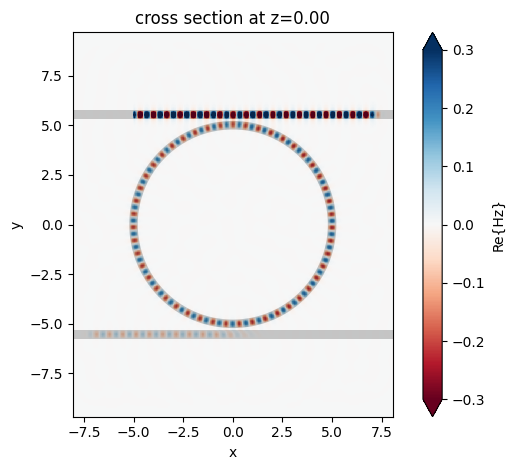

In [11]:
sim_data.plot_field("field", "Hz", val="real", vmin=-0.3, vmax=0.3)
plt.show()

Finally we plot the through and drop port transmission spectra. From here we can determine the free spectral range of the MRR. 

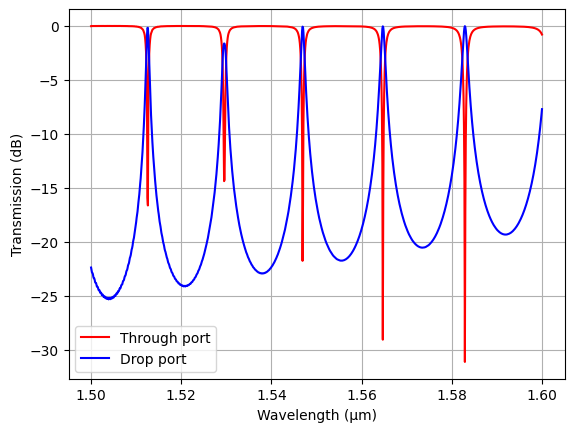

In [12]:
# extract transmission of the mode from the monitors
T_through = np.abs(sim_data["through"].amps.sel(mode_index=0, direction="+")) ** 2
T_drop = np.abs(sim_data["drop"].amps.sel(mode_index=0, direction="-")) ** 2

# plotting
plt.plot(ldas, 10 * np.log10(T_through), label="Through port", c="red")
plt.plot(ldas, 10 * np.log10(T_drop), label="Drop port", c="blue")
plt.xlabel("Wavelength (μm)")
plt.ylabel("Transmission (dB)")
plt.legend()
plt.grid()
plt.show()

We can also zoom in to one of the peaks and determine the Q-factor from the width of the peak. 

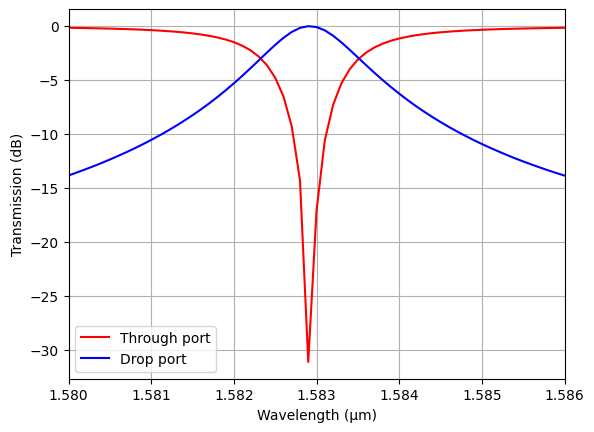

In [13]:
plt.plot(ldas, 10 * np.log10(T_through), label="Through port", c="red")
plt.plot(ldas, 10 * np.log10(T_drop), label="Drop port", c="blue")
plt.xlim(1.58, 1.586)
plt.xlabel("Wavelength (μm)")
plt.ylabel("Transmission (dB)")
plt.legend()
plt.grid()
plt.show()

## Final Remarks

In some cases, users might only be interested in determining the Q-factor of the ring. In that case, one can use the [ResonanceFinder](https://www.flexcompute.com/tidy3d/examples/notebooks/ResonanceFinder/) plugin and only run the simulation for a much shorter period of time. The plugin will analyze the time domain field profile and extract the Q-factor using harmonic inversion. 